In [234]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import re
SEED = 100

# EDA zbioru Shenzen

In [235]:
IMG_PATH = os.path.join(os.getcwd(), "SHENZEN/CXR_png/")
TXT_PATH = os.path.join(os.getcwd(), "SHENZEN/ClinicalReadings/")
imgs = os.listdir(IMG_PATH)
if "Thumbs.db" in imgs:
    imgs.remove("Thumbs.db")
txts = os.listdir(TXT_PATH)

## Przygotowanie ramki danych z metadanych

In [236]:
df_path = os.path.join(os.getcwd(), 'SHENZEN', 'dataframe.csv')
if (os.path.exists(df_path)):
    df = pd.read_csv(df_path)
    print("Dataframe loaded")
else:
    data = []
    n = len(imgs)
    for i in range(n):
        print(f'{i+1}/{n}', end='\r')
        img = cv2.imread(os.path.join(IMG_PATH, imgs[i]))
        with open(TXT_PATH + txts[i]) as f:
            reg = re.compile("([a-zA-Z]+)\W*([0-9]+)[ ]*[yrs]?.*")
            x = reg.search(f.read())
            data.append([os.path.join(IMG_PATH, imgs[i]),
                         x.group(1).lower(),
                         int(x.group(2)),
                         "H" if txts[i].endswith('0.txt') else "NH",
                         img.shape[0],
                         img.shape[1]])

    df = pd.DataFrame(data, columns=["img", "gender", "age", "condition", "img_height", "img_width"])
    df.to_csv(df_path)

Dataframe loaded


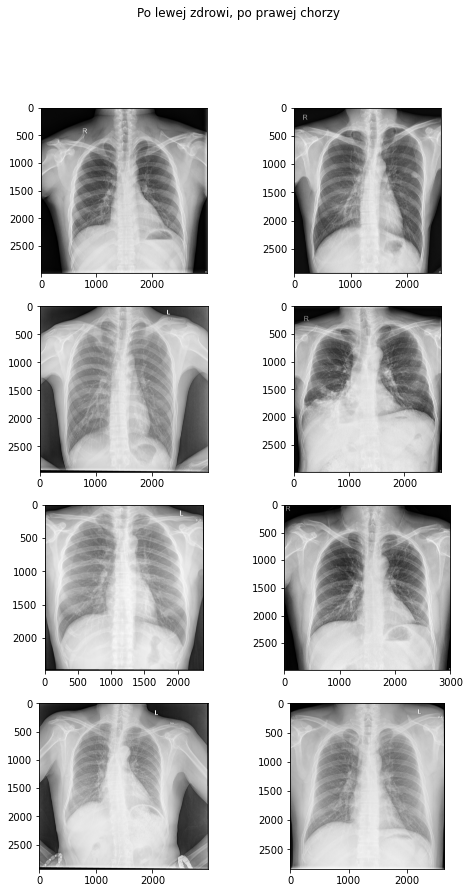

In [237]:
h = list(df[df['condition'] == 'H'].sample(4, random_state=SEED).loc[:, 'img'])
nh = list(df[df['condition'] == 'NH'].sample(4, random_state=SEED).loc[:, 'img'])
f, axes = plt.subplots(4, 2, figsize=(8, 14))
plt.suptitle("Po lewej zdrowi, po prawej chorzy")
for i in range(4):
    axes[i, 0].imshow(cv2.imread(os.path.join(IMG_PATH, h[i])))
    axes[i, 1].imshow(cv2.imread(os.path.join(IMG_PATH, nh[i])))

Jak widać, pacjenci zdrowi od chorych zwykle nie wydają się znacznie różnić (jak i również, bez wiedzy medycznej nieznane są nam oznaki choroby), co może być problematyczne. Natomiast przypadki ze znacznymi zmianami w płucach, jak na prawym zdjęciu w drugim rzędzie, powinny być proste do klasyfikacji.

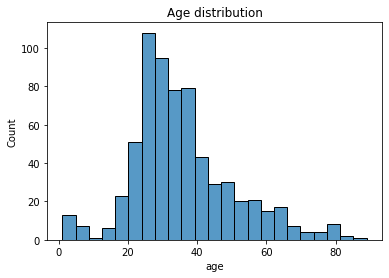

In [238]:
sns.histplot(data=df['age'])
plt.title("Age distribution")
plt.show()

Wiek pacjentów rozkłada się w miarę normalnie. Problemem mogą być dzieci, ponieważ będą się róznić od dorosłych.

In [239]:
df.groupby('gender').size()

gender
femal       3
female    210
male      449
dtype: int64

Mamy więcej mężczyzn jak i również 3 literówki w danych, które należy poprawić

In [240]:
df.loc[df["gender"] == "femal", "gender"] = "female"
df.groupby('gender').size()

gender
female    213
male      449
dtype: int64

In [241]:
df.groupby(['gender', 'condition']).size()

gender  condition
female  H            105
        NH           108
male    H            221
        NH           228
dtype: int64

Klasy H - healthy i NH - not healthy (Tuberculosis).
Odsetek chorych podobny - nie będzie problemu, że cechy którejś płci będą kojarzone z chorobą.

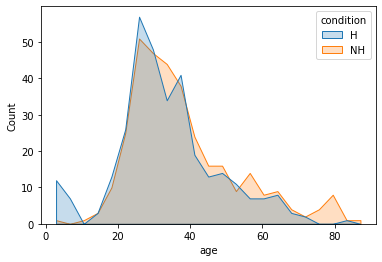

In [242]:
sns.histplot(data=df, x="age", hue="condition", element="poly")
plt.show()

Chorzy są przeważnie ludzie starsi, natomiast praktycznie wszystkie dzieci są zdrowe.

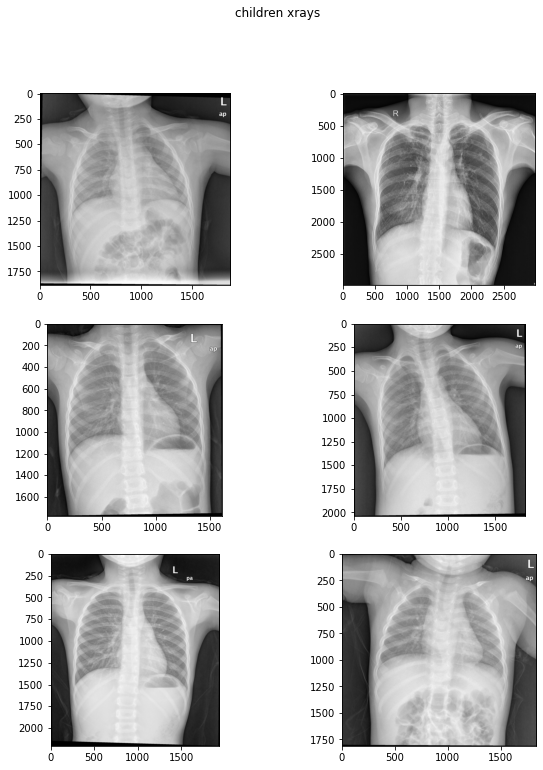

In [243]:
ch = list(df.loc[df["age"] < 10].sample(6, random_state=SEED).loc[:, "img"])

f, axes = plt.subplots(3, 2, figsize=(10, 12))

f.suptitle("children xrays")
        
for i in range(3):
    for j in range(2):
        axes[i, j].imshow(cv2.imread(ch[2*i + j]))

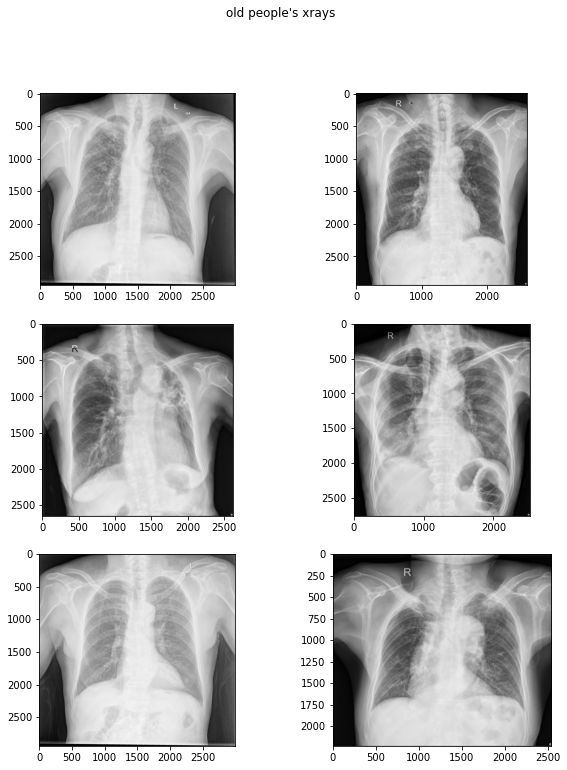

In [244]:
old = list(df.loc[df["age"] > 70].sample(6, random_state=SEED).loc[:, "img"])

f, axes = plt.subplots(3, 2, figsize=(10, 12))

f.suptitle("old people's xrays")
        
for i in range(3):
    for j in range(2):
        axes[i, j].imshow(cv2.imread(old[2*i + j]))

Jeśli model nauczy się od ludzi starszych (którzy są zwykle chorzy i ich zdjęcia różnią się znacznie od młodych lub zdrowych), że "niestandardowe" płuca są zawsze chore, może to powodować niepoprawne klasyfikowanie dzieci.

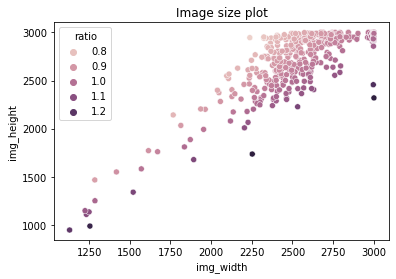

In [245]:
df["ratio"] = df["img_width"] / df["img_height"]

sns.scatterplot(data=df, x="img_width", y="img_height", hue="ratio")
plt.title("Image size plot")
plt.show()

Wymiary i proporcje zdjęć potrafią znacznie się różnić, co może powodować problemy w związku z potrzebą zmiany proporcji.

# EDA zbioru RSNA-pneumonia-detection-challenge

In [246]:
import pydicom
import matplotlib.patches as patches
IMG_PATH = os.path.join(os.getcwd(), 'RSNA', 'stage_2_train_images')
ldf = pd.read_csv(os.path.join(os.getcwd(), 'RSNA', 'stage_2_train_labels.csv'))
imgs = os.listdir(IMG_PATH)

## Przygotowanie ramki danych z metadanych

In [261]:
n = len(imgs)
df_path = os.path.join(os.getcwd(), 'RSNA', 'dataframe.csv')
if (os.path.exists(df_path)):
    df = pd.read_csv(df_path)
    print("Dataframe loaded")
else:
    data = [[None] for _ in range(n)]
    for i in range(n):
        print(f'{i+1}/{n}', end='\r')
        img = os.path.join(IMG_PATH, imgs[i])
        ds = pydicom.dcmread(img)
        data[i] = [ds.PatientID, ds.PatientSex, ds.PatientAge, ds.ViewPosition,
                   ds.PhotometricInterpretation, ds.PixelSpacing, img]
        
    df = pd.DataFrame(data, columns=["ID", "Sex", "Age", "View_position", "Phot_int", "Pixel_spacing", 'Img'])
    df.to_csv(df_path, index=False)


Dataframe loaded


In [262]:
df.head()

,ID,Sex,Age,View_position,Phot_int,Pixel_spacing,Img
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,F,51,PA,MONOCHROME2,"[0.14300000000000002, 0.14300000000000002]",C:\Users\Patryk\Desktop\Kod\WB-DATA\RSNA\stage...
1,000924cf-0f8d-42bd-9158-1af53881a557,F,19,AP,MONOCHROME2,"[0.139, 0.139]",C:\Users\Patryk\Desktop\Kod\WB-DATA\RSNA\stage...
2,000db696-cf54-4385-b10b-6b16fbb3f985,F,25,AP,MONOCHROME2,"[0.168, 0.168]",C:\Users\Patryk\Desktop\Kod\WB-DATA\RSNA\stage...
3,000fe35a-2649-43d4-b027-e67796d412e0,M,40,AP,MONOCHROME2,"[0.171, 0.171]",C:\Users\Patryk\Desktop\Kod\WB-DATA\RSNA\stage...
4,001031d9-f904-4a23-b3e5-2c088acd19c6,M,57,PA,MONOCHROME2,"[0.139, 0.139]",C:\Users\Patryk\Desktop\Kod\WB-DATA\RSNA\stage...


In [263]:
ldf.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [264]:
df = pd.merge(df, ldf, left_on="ID", right_on="patientId")
df.head()

,ID,Sex,Age,View_position,Phot_int,Pixel_spacing,Img,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,F,51,PA,MONOCHROME2,"[0.14300000000000002, 0.14300000000000002]",C:\Users\Patryk\Desktop\Kod\WB-DATA\RSNA\stage...,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,000924cf-0f8d-42bd-9158-1af53881a557,F,19,AP,MONOCHROME2,"[0.139, 0.139]",C:\Users\Patryk\Desktop\Kod\WB-DATA\RSNA\stage...,000924cf-0f8d-42bd-9158-1af53881a557,NaN,NaN,NaN,NaN,0
2,000db696-cf54-4385-b10b-6b16fbb3f985,F,25,AP,MONOCHROME2,"[0.168, 0.168]",C:\Users\Patryk\Desktop\Kod\WB-DATA\RSNA\stage...,000db696-cf54-4385-b10b-6b16fbb3f985,316.0,318.0,170.0,478.0,1
3,000db696-cf54-4385-b10b-6b16fbb3f985,F,25,AP,MONOCHROME2,"[0.168, 0.168]",C:\Users\Patryk\Desktop\Kod\WB-DATA\RSNA\stage...,000db696-cf54-4385-b10b-6b16fbb3f985,660.0,375.0,146.0,402.0,1
4,000fe35a-2649-43d4-b027-e67796d412e0,M,40,AP,MONOCHROME2,"[0.171, 0.171]",C:\Users\Patryk\Desktop\Kod\WB-DATA\RSNA\stage...,000fe35a-2649-43d4-b027-e67796d412e0,570.0,282.0,269.0,409.0,1


In [265]:
df["Phot_int"].value_counts()

MONOCHROME2    30227
Name: Phot_int, dtype: int64

Wszystkie zdjęcia są MONOCHROME2, więć możemy pozbyć się tej zmiennej, jak i niepotrzebnego patientId.

In [266]:
df.drop(["Phot_int", "patientId"], axis=1, inplace=True)

In [267]:
df.dtypes

ID                object
Sex               object
Age                int64
View_position     object
Pixel_spacing     object
Img               object
x                float64
y                float64
width            float64
height           float64
Target             int64
dtype: object

Wiek został zapisany jako String, należy to zmienić.

In [268]:
df['Age'] = df['Age'].astype('int')

In [269]:
df.describe()

,Age,x,y,width,height,Target
count,30227.000000,9555.000000,9555.000000,9555.000000,9555.000000,30227.000000
mean,46.797764,394.047724,366.839560,218.471376,329.269702,0.316108
std,16.892940,204.574172,148.940488,59.289475,157.750755,0.464963
min,1.000000,2.000000,2.000000,40.000000,45.000000,0.000000
25%,34.000000,207.000000,249.000000,177.000000,203.000000,0.000000
50%,49.000000,324.000000,365.000000,217.000000,298.000000,0.000000
75%,59.000000,594.000000,478.500000,259.000000,438.000000,1.000000
max,155.000000,835.000000,881.000000,528.000000,942.000000,1.000000


Maksymalny wiek wynosi 155, co oznacza, że część danych jest błędnych i należałoby się ich pozbyć.

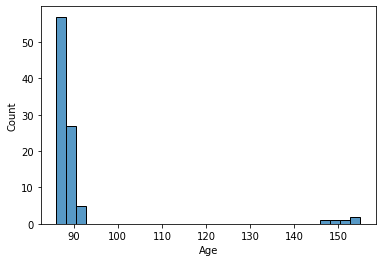

In [282]:
sns.histplot(x=df.loc[df['Age'] > 85, 'Age'], bins=30)
plt.show()

Na wykresie od razu widać, że problemem jest parę pacjentów w wieku ok. 150 lat.

In [285]:
print(f"Usuwamy {len(df[df['Age'] > 100])} pacjentow starszych niż 100 lat")
df.drop(df[df['Age'] > 100].index, inplace=True)

Usuwamy 5 pacjentow starszych niż 100 lat


In [286]:
len(df)

30222

Obrazów jest jedynie 26684. Jak dużo pacjentów ma kilka oznak zapalenia płuc?

In [287]:
mul = df['ID'].value_counts().to_frame(name="N")
mul.reset_index()
mul = mul[mul['N'] > 1]
mul.value_counts()

N
2    3266
3     119
4      13
dtype: int64

Znaczna część pacjentów ma 2, niewielu ma 3 i 4.

Na rzecz analizy, stworzymy również drugą ramkę danych, gdzie będzie znajdować się tylko pojedyńczy wpis dla każdego pacjenta.

In [288]:
df_s = df.drop_duplicates(subset="ID")
len(df_s)

26679

Zobaczmy rozkłady zmiennych.

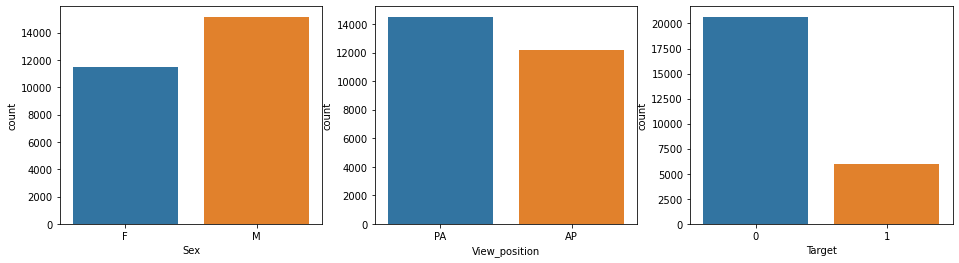

In [289]:
fig, axs = plt.subplots(1, 3, figsize=(16,4))
sns.countplot(x="Sex", data=df_s, ax=axs[0])
sns.countplot(x="View_position", data=df_s, ax=axs[1])
sns.countplot(x="Target", data=df_s, ax=axs[2])

plt.show()

Target 0 - zdrowi, 1 - chorzy

In [376]:
df_s.groupby(['Sex', 'Target']).size()

Sex  Target
F    0          9014
     1          2502
M    0         11653
     1          3510
dtype: int64

Odsetek chorych podobny - nie będzie problemu, że cechy, którejś płci będą kojarzone z chorobą.

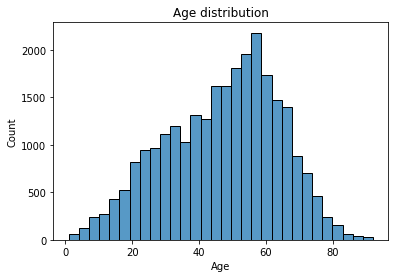

In [293]:
sns.histplot(data=df_s['Age'], bins=30)
plt.title("Age distribution")
plt.show()

Wszystkie rozkłądy nie wykazują żadnych anomalii i nie powinny sprawiać problemu. Jednak tak jak w przypadku poprzedniego zbioru, problematyczne mogą być zdjęcia osób najstarszych i najmłodszych. 

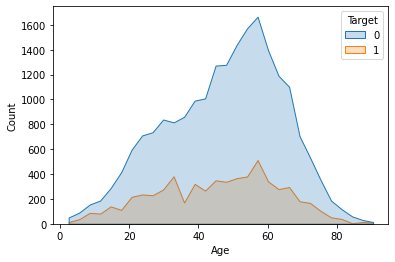

In [295]:
sns.histplot(data=df_s, x="Age", hue="Target", element="poly", bins=30)
plt.show()

Nie występuje tu jednak ten sam problem co w zbiorze poprzednim, że dzieci są w dużej większości zdrowe, a starsi chorzy.

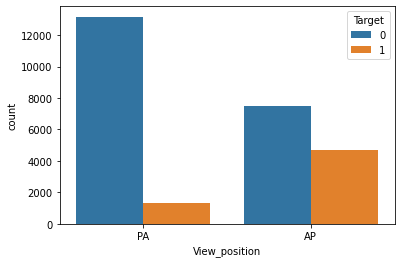

In [297]:
sns.countplot(data=df_s, x="View_position", hue="Target")
plt.show()

Natomiast niestety pojawia się tutaj wspomniany na laboratoriach problem - zdjęcia AP robione są najczęściej dla osób ciężko chorych, a więc jest ich zdecydowanie większy odsetek niż w przypadku zdjęć PA. Formaty te różnią się, i uważać będzie trzeba na to, aby model nie nauczył się kojarzyć cech obrazów AP z chorobą.

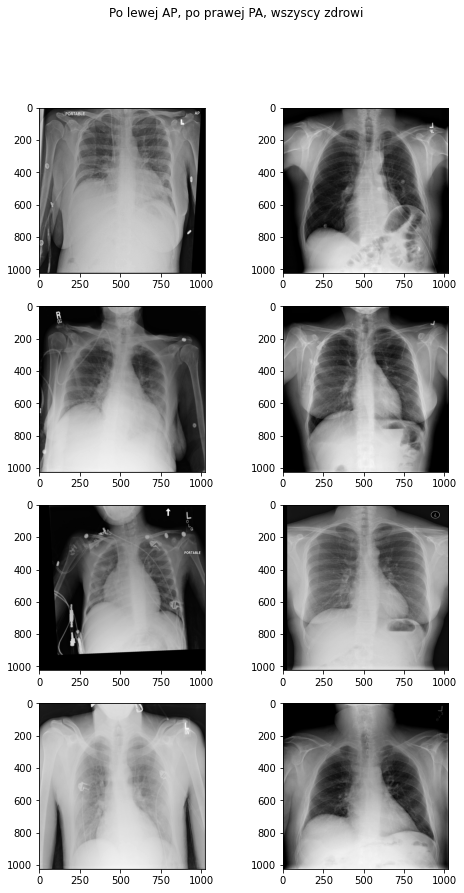

In [330]:
ap = list(df_s[(df_s['View_position'] == 'AP') & (df_s['Target'] == 0)].sample(4, random_state=SEED).loc[:, 'Img'])
pa = list(df_s[(df_s['View_position'] == 'PA') & (df_s['Target'] == 0)].sample(4, random_state=SEED).loc[:, 'Img'])

f, axes = plt.subplots(4, 2, figsize=(8, 14))
plt.suptitle("Po lewej AP, po prawej PA, wszyscy zdrowi")
for i in range(4):
    axes[i, 0].imshow(pydicom.dcmread(ap[i]).pixel_array, cmap='gray')
    axes[i, 1].imshow(pydicom.dcmread(pa[i]).pixel_array, cmap='gray')

Od razu widoczne jest jak bardzo niestandardowe są zdjęcia AP.

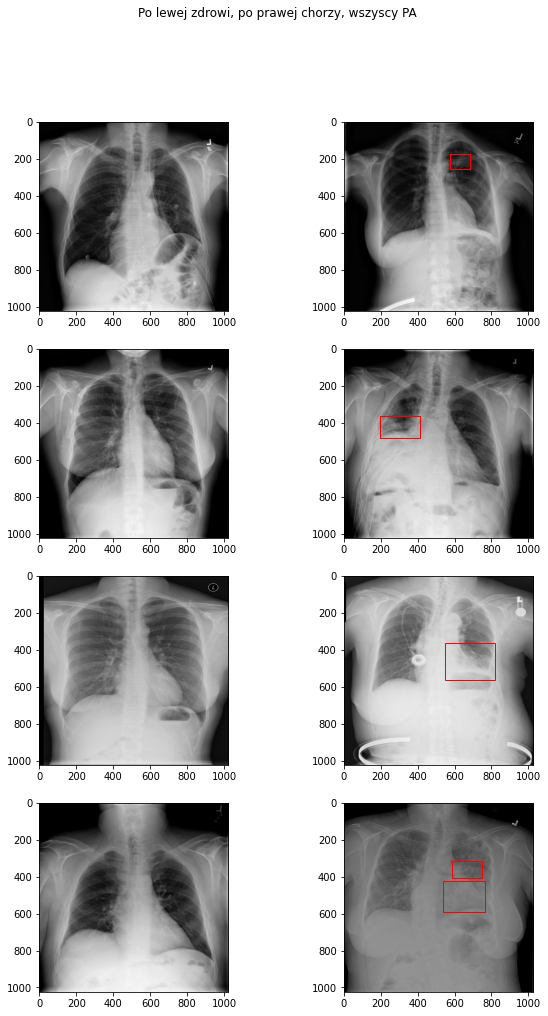

In [411]:
h = list(df_s[(df_s['View_position'] == 'PA') & (df_s['Target'] == 0)].sample(4, random_state=SEED).loc[:, 'Img'])
nh = list(df_s[(df_s['View_position'] == 'PA') & (df_s['Target'] == 1)].sample(4, random_state=SEED).loc[:, 'ID'])

f, axes = plt.subplots(4, 2, figsize=(10, 16))
plt.suptitle("Po lewej zdrowi, po prawej chorzy, wszyscy PA")
for i in range(4):
    rec = df[df['ID'] == nh[i]]
    axes[i, 0].imshow(pydicom.dcmread(h[i]).pixel_array, cmap='gray')
    axes[i, 1].imshow(pydicom.dcmread(rec.iloc[0]['Img']).pixel_array, cmap='gray')
    
    for j in range(len(rec)):
        row = rec.iloc[j]
        rect = patches.Rectangle((row['x'], row['y']), row['width'], row['height'], linewidth=1, edgecolor='r', facecolor='none')
        axes[i, 1].add_patch(rect)
        

Problematyczny okazuje się fakt, że bez wiedzy medycznej, można się jedynie domyślać dlaczego akurat dane fragmenty są zaznaczone (zwykle wydają się to być jaśniejsze w środku płuc), co znacznie utrudniać będzie zidentyfikowanie błędnego kodu, o ile taki się pojawi. Warto również zauważyć, że zdjęcie w prawym dolnym rogu jest ciemniejsze od pozostałych - co może zmylić sieć neuronową (więcej o tym w dziale 'Wnioski').

# Wnioski
- W zbiorze Shenzen nie występują zdjęcia AP, przez co zdjęcia są bardziej "standardowe", gdzie w przypadku zbioru RSNA, pojawia się np. zdjęcie, które jest odrobinę obrócone - prawdopodobnie potrzebna będzie dodatkowa obróbka zdjęć
- Zdjęcia w zbiorze Shenzen są różnych proporcji, co może mieć bardzo negatywny wpływ, ponieważ będzie trzeba je przeskalować i wymiary klatki piersiowej mogą być nienaturalne
- W zbiorze Shenzen jest około 40 razy mniej zdjęć, więc sieć neuronowa może mieć problem z nauczeniem się
- Zdjęcia PA różnią się od AP i dla zdjęć PA odsetek chorych jest wielokrotnie większy i model może nauczyć się identyfikować zdjęcia po tym czy zdjęcia są AP czy PA
- Przeglądając zdjęcia za pomocą programu do przeglądania plików DICOM, zauważalna jest kolejna różnica między zbiorami: w zbiorze RSNA, zdarzają się zdjęcia, które są jaśniejsze bądź ciemniejsze od pozostałych. Zdjęcia te wymagały będą normalizacji. W przypadku zbioru Shenzen problem ten wydaje się nie występować.